**Experimental Description**: Experimental data was collected for steady state was measured for four strains, each containing four different beta-estradiol inducible cascades. Each of the four strains was induced with eighteen different doses of βe ranging from 0 to 100 μM in a single batch of seventy-two cultures. Cells were diluted every eight hours to prevent culture saturation. Steady-state fluorescence readings were taken after five days when the cultures were in log-phase. 

**Model Description**: A series of hill-functions B (table X) was used to fit kinetics and dose-response data independently using the same model. For the steady-state model, a βe-to-expression transfer function was created from a βe inducible yeast-enhanced YFP (data not shown). Relative expression of sgRNA was normalized to an equivalent dose of 100 μM βe and multiplied by the parameter u.

**Fitting Procedure**: Parameters were optimized using differential evolution (DE) followed by minimization using the Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm. One hundred optimal fits were generated using DE/BFGS. Parameter distributions exhibited a non-normal distribution with a single clear central tendency. Parameter mean and uncertainty in the fitting parameters were determined by taking the means and variances of the one hundred parameter sets. 

**Monte-Carlo Simulations**: Averages and standard deviations of a1-4 and k1-4 were used to determine global parameters for a and k. Parameter uncertainty For model projections and Monte-Carlo simulations parameter distributions were assumed to be normally distributed around the mean. 10,000 simulations were generated from parameter distributions using the model.

* Reference for Diff. Evo.: Storn, R and Price, K, Differential Evolution - a Simple and Efficient Heuristic for Global Optimization over Continuous Spaces, Journal of Global Optimization, 1997, 11, 341 - 359. *

***

<h1> Determine Parameter Uncertainties from Fits </h1>

***

In [45]:
import os
import pandas as pd
from IPython import display
import scipy  
import scikits.bootstrap as bootstrap
%matplotlib inline

def getParamUncertainties(filename, chooseb=0):
    pds = pd.read_csv(filename, header=[0,1], index_col=0)
    pds.drop(pds.columns[12:15], axis=1, inplace=True)
    
    pds['weight'] = pds['score'].apply(lambda x: (1.0/x)**1)
    #CIs = bootstrap.ci(data=pds, statfunction=scipy.mean)
    #print CIs
    average = pds.apply(np.mean)
    std = pds.apply(np.std)
    a_mean = np.average(average['a'], weights=std['a'])
    a_var = np.average((average['a'] - a_mean)**2, weights=std['a'])
    a_std = np.sqrt(a_var)
    
    k_mean = np.average(average['k'], weights=std['k'])
    k_var = np.average((average['k'] - k_mean)**2, weights=std['k'])
    k_std = np.sqrt(k_var)
    
    b_mean = average['b'][chooseb]
    b_std = std['b'][chooseb]
    u_mean = average['u'][0]
    u_std = std['u'][0]
    n_mean = average['n']
    n_std = std['n']
    
    labels = list('akbun')
    means = a_mean, k_mean, b_mean, u_mean, n_mean
    sd = [a_std, k_std, b_std, u_std, n_std]
    means = [float(x) for x in means]
    sd = [float(x) for x in sd]
    globalparams = pd.DataFrame([means, sd], columns=labels, index=["mean", "std"]).transpose()
    modelparams = pd.DataFrame([average, std], index=["mean", "std"]).transpose()
    modelparams.drop('weight', level=0, axis=0, inplace=True)
    modelparams.drop('score', level=0, axis=0, inplace=True)
    return modelparams, globalparams
analysisfolder = "/Users/Justin/Documents/Programming/CRISPRCascadeAnalysis/"
hyakfolder = analysisfolder + "Data/hyakfitting_results/"

combined_filename = hyakfolder + "bestfits_combined_indexed.csv"
m, g = getParamUncertainties(combined_filename)
m

mean       std
a 0  1.019817  0.003054
  1  0.444067  0.109886
  2  0.599496  0.147607
  3  0.583732  0.143713
k 0  0.805262  0.281558
  1  0.495397  0.173047
  2  0.528830  0.185329
  3  0.539853  0.190868
b 0  0.095336  0.000249
  1  0.087488  0.000219
u 0  0.413750  0.101783
n 0  1.511766  0.005585

***

<h1> Modeling Definitions </h1>

***

In [135]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy import optimize
import pylab as plt
import pandas as pd
from glue import qglue
%matplotlib inline


def cascade_kinetics(t, r, a, k, b, u, n):
    layer_depth = len(r) - 1
    dR = [0] * len(r)
    dR[layer_depth] = u - b * r[layer_depth]
    for l in range(layer_depth)[::-1]:
        dR[l] = a[l] / (1+k[l] * r[l+1] ** n) - b * r[l]
    return dR

def cascade_ss(layer_depth, a, k, b, u, n):
    assert len(a) == len(k)
    assert len(a) >= layer_depth
    R = [0]*(layer_depth+1)
    R[layer_depth] = u/b
    for l in range(layer_depth)[::-1]:
        R[l] = a[l] / ((1+k[l] * R[l+1] ** n)*b)
    return np.array(R)

def tfxn(inducer_at_max, inducer):
    AB = 542.8745566
    K = 0.269635359
    n = 1.238933919
    def fxn(u):
        return (AB*K*u**n)/(1+K*u**n)
    rel_induction = fxn(inducer)/fxn(inducer_at_max)
    return rel_induction

t_final = 500.
dt = 1.0


def integrateSystem(numlayers, a, k, b, u, n):
    ss = cascade_ss(numlayers, a, k, b, 0.0, n)
    r1 = integrate.ode(cascade_kinetics)
    r1.set_initial_value(ss).set_f_params(a, k, b, u, n)
    data1 = []
    while r1.successful() and r1.t < t_final:
        r1.integrate(r1.t+dt)
        data1.append( [r1.t] + [float(i) for i in list(r1.y)] )
    return data1


def ssModel(i_array, a, k, b, u, n):
    assert len(a) == len(k)
    num_layers = len(a)+1
    dose = pd.DataFrame(index = i_array, columns = list(range(1,num_layers+1)) + ['rel exp'])
    for i in i_array:
        rel_exp = tfxn(100.0, i)
        rel_u = rel_exp * u
        dose.loc[i] = [cascade_ss(l, a, k, b, rel_u, n)[0] for l in range(num_layers)] + [rel_exp]
    return dose


def kineticsModel(a, k, b, u, n):
    assert len(a) == len(k)
    num_layers = len(a)+1
    layers = {}
    time = []
    for l in range(num_layers):
        system = integrateSystem(l, a, k, b, u, n)
        unzipped = zip(*system)
        layers[l] = unzipped[1]
        time = unzipped[0]
    return pd.DataFrame(layers, index=time)


def getTimeToHalfMaximum(trajectory, init, ss, ds):
    half = ss - init
    half = half/2.0
    half = ss - half
    ttss = []
    g = np.abs(trajectory - half)
    ttss = g.apply(np.argmin)
    return ttss

def getValue(t, df):
    i = np.abs(df.index - t).argmin()
    return df.iloc[i]

def cascadesystem_steadystate_simple(numlayers, a, k, b, u, n):
    
    Y = []
    Y.append(u/b)
    for i in range(numlayers):
        Y.append((1.*a/(1+k*Y[i]**n))/b)
    return np.array(Y)

def dynamic_range_plot(numlayers, a, k, b, u, n):
    params = [a,k,b,u,n]
    ss = cascadesystem_steadystate_simple(numlayers, *params)
    params = [a, k, b, 0.0, n]
    ss_0 = cascadesystem_steadystate_simple(numlayers, *params)
    #plt.yscale('log')
    #plt.plot(np.log10(np.abs(ss-ss_0)))
    dr = []
    for ss_value, ss_0_value in zip(ss, ss_0):
        values = [ss_value, ss_0_value]
        dr.append(max(values)/min(values))
    #return np.abs(ss-ss_0)
    metric = 20.0*np.log10(dr)
    #metric = np.abs(ss-ss_0)
    plt.plot(metric)
    return metric


***

<h1> Monte Carlo Simulations </h1>

***

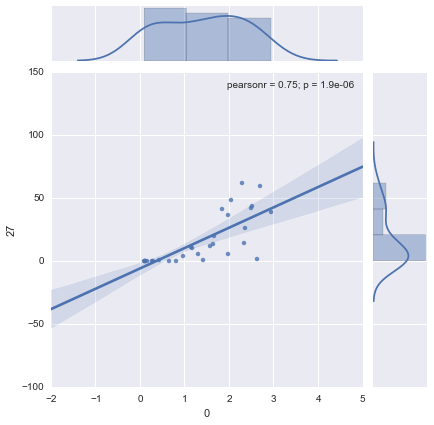

KeyboardInterrupt: 

In [156]:
from IPython import display
import os
import seaborn as sns

############################################################################
# Generate a random parameter set from parameter sd and means
############################################################################

def generateRandomParameterSet(numlayers, numparams, labels, mean_array, std_array, param_iter, distribution, implyParams):
    assert len(labels) == len(param_iter)
    if not implyParams:    
        display.display(len(std_array))
        display.display(np.sum(param_iter))
        assert len(mean_array) == np.sum(param_iter)
        assert len(std_array) == np.sum(param_iter)
        
    # Determine index and high/low values
    low = []
    high = []
    index = []
    for i, key in enumerate(labels):
        index = index + zip([key]*param_iter[i], range(param_iter[i]))
    for mn, sd in zip(mean_array, std_array):
        low = low + [mn - sd]
        high = high + [mn + sd]
    
    if implyParams:
        _mean_array = []
        _std_array = []
        _low = []
        _high = []
        for i in range(len(mean_array)):
            _mean_array = _mean_array + [mean_array[i]] * param_iter[i]
            _std_array = _std_array + [std_array[i]] * param_iter[i]
            _low = _low + [low[i]] * param_iter[i]
            _high = _high + [high[i]] * param_iter[i]
        mean_array = _mean_array
        std_array = _std_array
        low = _low
        high = _high
    # Generate DataFrame
    ran_params = []
    for i in range(numparams):
        if distribution == "uniform":
            r = np.random.uniform(low, high)
        else:
            r = np.random.normal(mean_array, std_array)
        while (r < 0).any():
            if distribution == "uniform":
                r = np.random.uniform(low, high)
            else:
                r = np.random.normal(mean_array, std_array)
            #r = r.clip(param_means-2*param_sd, param_means+2*param_sd) #clip by two standard deviations
        ran_params.append(r)
    ran_params = pd.DataFrame(ran_params, columns=pd.MultiIndex.from_tuples(index))
    return ran_params

############################################################################
### Extract parameters from a parameter data frame with multi-indexed columns
############################################################################

def extractParameters(paramSeries):
    p = paramSeries
    a = np.array(p['a'])
    k = np.array(p['k'])
    b = float(p['b'])
    u = float(p['u'])
    n = float(p['n'])
    return a, k, b, u, n

############################################################################
### Analyzes a system of parameters
############################################################################
def analyzeSystem(numlayers, samplenum, labels, mean_array, std_array, param_iter, implyParams, trajectories=None, doseresponses=None, distribution="normal"):
    ranParams = generateRandomParameterSet(numlayers, samplenum, labels, mean_array, std_array, param_iter, distribution, implyParams)
    ss_array = []
    ss_0_array = []
    dr_array = []
    metric_array = []
    ttss_array = []
    for i in range(len(ranParams)):
        a, k, b, u, n = extractParameters(ranParams.iloc[i])
        # Get Dynamic Range
        ss = cascade_ss(numlayers, a, k, b, u, n)
        ss_0 = cascade_ss(numlayers, a, k, b, 0.0, n)
        dr = []
        for ss_value, ss_0_value in zip(ss, ss_0):
            values = [ss_value, ss_0_value]
            dr.append(max(values)/min(values))
        dr = 20.0 * np.log10(np.array(dr))
        metric = np.log10(np.abs(ss-ss_0))
        metric_array.append(metric)
        ss_array.append(ss)
        ss_0_array.append(ss_0)
        dr_array.append(dr)
        traj = integrateSystem(len(a), a, k, b, u, n)
        
        #traj = kineticsModel(a, k, b, u, n)
        traj = pd.DataFrame(traj)
        traj = traj.set_index(0) #only for integrate system, comment if using kinetics model
        traj.reindex()
        
        # fix the trajectory for the kinetics model
        # you might have add the 0th layer and then reverse the columns
        traj = pd.DataFrame(traj)
        if not trajectories == None:
            trajectories.append(traj)
        if not doseresponses == None:
            # Store SSModel
            ss_model = ssModel(0.006 * 2 ** np.linspace(0,15,50), a, k, b, u, n)
            doseresponses.append(ss_model)
        ttss_array.append(getTimeToHalfMaximum(traj, ss_0, ss, 0.001))
        d1 = np.array(dr_array)[1:]
        d2 = np.array(dr_array)[:-1]
        index = pd.MultiIndex.from_tuples(
            zip(['ss']*(numlayers+1), range(numlayers+1)) +
            zip(['ss_0']*(numlayers+1), range(numlayers+1)) +
            zip(['dr']*(numlayers+1), range(numlayers+1))
        )
        
        l = len(metric_array[0])
        index = pd.MultiIndex.from_tuples(
            zip(['metric']*l, range(l))
            )
        metric_df = pd.DataFrame(metric_array, columns=index)

        l = len(ss_array[0])
        index = pd.MultiIndex.from_tuples(
            zip(['ss']*l, range(l))
            )
        ss_df = pd.DataFrame(ss_array, columns=index)

        l = len(ss_0_array[0])
        index = pd.MultiIndex.from_tuples(
            zip(['ss_0']*l, range(l))
            )
        ss_0_df = pd.DataFrame(ss_0_array, columns=index)

        l = len(dr_array[0])
        index = pd.MultiIndex.from_tuples(
            zip(['dr']*l, range(l))
            )
        dr_df = pd.DataFrame(dr_array, columns=index)

        l = len(ttss_array[0])
        index = pd.MultiIndex.from_tuples(
            zip(['ttss']*l, range(l))
            )
        ttss_df = pd.DataFrame(np.array(ttss_array), columns=index)
        m = ranParams.join(ss_df).join(ss_0_df).join(ttss_df).join(dr_df).join(metric_df)
        #newtrajname = str(uuid.uuid4()) + ".csv"
        #m['trajectoryfile'] = newtrajname
        #traj.to_csv(analysisFolder + "/MonteCarlo/Trajectories/" + newtrajname)
    return m

def modelSampling(modelparams, numsamples, distribution):
    mn = modelparams.copy()
    mn = mn.drop('weight', level=0, axis=0)
    mn = mn.drop('score', level=0, axis=0)
    mns = list(mn['mean'])
    mns = mns[:9] + mns[10:]
    stds = list(mn['std'])
    stds = list(stds)
    stds = stds[:9] + stds[10:]
    return generateRandomParameterSet(1,
                                      numsamples,
                                      list("akbun"),
                                      mns, stds, [4, 4, 1, 1, 1], distribution, implyParams)


def sampling(filename, layers, numsamples, reps, labels, mean_array, std_array, param_iter, implyParams, overwrite=False, distribution="normal", trajectories=None, doseresponses=None):
    dt = 1.0
    t_final = 500.
    total_p = None
    
    if not os.path.isfile(filename) or overwrite:
        new_p = analyzeSystem(layers, 
                              numsamples, 
                              labels, 
                              mean_array, 
                              std_array,
                              param_iter,
                              implyParams = implyParams,
                              trajectories=trajectories, 
                              doseresponses=doseresponses,
                              distribution=distribution)
        new_p.to_csv(filename)
    for i in range(reps):
        new_p = analyzeSystem(layers, 
                              numsamples, 
                              labels, 
                              mean_array, 
                              std_array,
                              param_iter,
                              implyParams = implyParams,
                              trajectories=trajectories, 
                              doseresponses=doseresponses,
                              distribution=distribution)
        read_p = pd.read_csv(filename, header=[0,1], index_col=0)
        read_p.columns = new_p.columns
        total_p = pd.concat([new_p, read_p], ignore_index=True)
        total_p.to_csv(filename)
        display.clear_output(wait=True)
        #plt.plot(range(i))
        sns.jointplot(total_p['n'][0], total_p['dr'][27], kind='reg')
        plt.show()
        display.display(plt.gcf())
    return filename, total_p, trajectories, doseresponses    


modeltrajectories = []
modelsteadystates = []
"""
f, test = sampling(analysisFolder + "/modelingtest.csv", #filename
                   4,                         #number of layers
                   10,                        #number of samples to generate per round
                   5,                         #number of rounds
                   ["a", "k", "b", "u", "n"], #parameter labels
                   mns,                       #parameter means
                   np.array(stds)*1,                      #parameter stds
                   [4, 4, 1, 1, 1],           #multiply paramters
                   False,                     #infer paramters from the multiply parameters value
                   distribution="normal",     #paramter random distribution
                   overwrite=True,            #overwrite the file name
                   trajectories=modeltrajectories, #saving kinetic trajectories
                   doseresponses=modelsteadystates #saving steady state models
                  )
"""
################################### Define Filenames ###################################

root = "/Users/Justin/Documents/Programming/CRISPRCascadeAnalysis/"
datafolder = os.path.join(root, "Data")
montecarlofolder = os.path.join(datafolder, "MonteCarlo")
hyakfolder = os.path.join(root, "hyakfitting_results")
analysisfolder = "/Users/Justin/Documents/Programming/CRISPRCascadeAnalysis/"
hyakfolder = analysisfolder + "Data/hyakfitting_results/"

combined_filename = os.path.join(hyakfolder, "bestfits_combined_indexed.csv")
kinetics_filename = os.path.join(hyakfolder, "bestfits_kinetics_indexed.csv")
steadystate_filename = os.path.join(hyakfolder, "bestfits_steadystate_indexed.csv")

numlayers = 30
numrounds = 10
numsamples = 10
overwrite = False
modelparams, globalparams = getParamUncertainties(combined_filename)
display.display(modelparams)
display.display(globalparams)

fl = combined_filename

prefix = "normal_distribution"
fl = "_".join([prefix, os.path.basename(fl)])
normal_results  = sampling(
                   os.path.join(montecarlofolder, fl),
                   numlayers,
                   numrounds,
                   numrounds,
                   list("akbun"),
                   list(globalparams['mean']),
                   list(globalparams['std']),
                   [numlayers, numlayers, 1, 1, 1],
                   True,
                   distribution="normal",
                   overwrite=overwrite, #,
                   trajectories=[], #saving kinetic trajectories
                   doseresponses=[]) 

prefix = "uniform_distribution"
fl = "_".join([prefix, os.path.basename(fl)])
uniform_results  = sampling(
                   os.path.join(montecarlofolder, fl),
                   numlayers,
                   numrounds,
                   numrounds,
                   list("akbun"),
                   list(globalparams['mean']),
                   np.array(globalparams['mean'])*0.95,
                   [numlayers, numlayers, 1, 1, 1],
                   True,
                   distribution="uniform",
                   overwrite=overwrite, #,
                   trajectories=[], #saving kinetic trajectories
                   doseresponses=[]) 

prefix = "n_uniform_distribution"
fl = "_".join([prefix, os.path.basename(fl)])
nvary = globalparams['std']
nvary['n'] = globalparams['mean']['n']*0.95
n_uniform_results  = sampling(
                   os.path.join(montecarlofolder, fl),
                   numlayers,
                   numrounds,
                   numrounds,
                   list("akbun"),
                   list(globalparams['mean']),
                   np.array(globalparams['mean'])*0.9,
                   [numlayers, numlayers, 1, 1, 1],
                   True,
                   distribution="uniform",
                   overwrite=overwrite, #,
                   trajectories=[], #saving kinetic trajectories
                   doseresponses=[]) 

In [163]:
df = pd.read_csv(os.path.join(montecarlofolder, "uniform_distribution_bestfits_combined_indexed.csv"))
bins = np.linspace(df.n.min(), df.n.max(), 0.1)
groups = df.groupby(pd.cut(df.a, bins))
groups

<h1> Kinetics Layers vs Time to half maximal plot </h1>

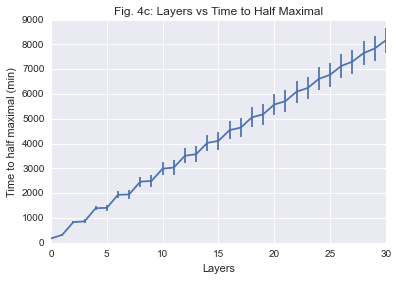

In [134]:
import pandas as pd
import numpy as np
import pylab as plt

read_p = pd.read_csv(os.path.join(montecarlofolder, "normal_distribution_bestfits_combined_indexed.csv"), header=[0,1], index_col=0)
ttss = read_p['ttss']
ttss = ttss.transpose()
ttss = ttss.set_index(np.arange(31)[::-1])
ttss = ttss.apply(lambda x: x * 25.)
ttss_mean = ttss.apply(np.mean, axis=1)
ttss_sd = ttss.apply(np.std, axis=1)
#plt.plot(ttss_mean.index, ttss_mean)
plt.figure()
plt.title("Fig. 4c: Layers vs Time to Half Maximal")
plt.xlabel("Layers")
plt.ylabel("Time to half maximal (min)")
plt.errorbar(ttss_mean.index, ttss_mean, yerr=ttss_sd)

#Prepare for dataframes for saving
ttss_df = pd.DataFrame(ttss_mean)
ttss_df['layers'] = np.arange(31)[::-1]
ttss_df.columns = ['time to half max (min)', 'layers']
ttss_df['sd'] = ttss_sd
ttss_df.to_csv(datafolder + "/TimeToHalfMax.csv")

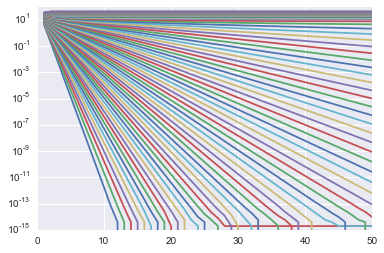

,mean,std
a,0.554819,0.077420
k,0.618081,0.134877
b,0.095336,0.000249
u,0.413750,0.101783
n,1.511766,1.436177


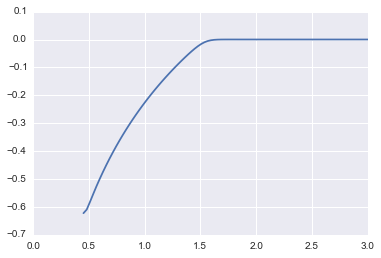

In [152]:
n_array = []    
metric = []
logslope = []
dr_plots = []
for n in np.linspace(0.1, 3.0, 100):
    p = list(globalparams['mean'])
    p[-1] = n
    dr_plot = dynamic_range_plot(50, *p)
    dr_plots.append(dr_plot)
    logslope.append(np.log10(dr_plot[25]/dr_plot[15])/10.0)
    n_array.append(n)
metric = np.array(metric)
n_array = np.array(n_array)
logslope = np.array(logslope)
plt.yscale('log')
#plt.legend()
plt.show()

display.display(globalparams)
metriccsv = pd.DataFrame([n_array, 1.0*np.array(metric)]).transpose()
metriccsv.columns = ["n", "Metric"]
#metriccsv
plt.plot(n_array, logslope)

<h1> Metric: Log Slope </h1>

np.log10(dr_plot[25]/dr_plot[15])/10.0

$$ dynamic range = \rho  = 20.0log_{10}(\frac{max}{min}) $$
$$ η = log_{10}(\frac{\rho_{i+1}}{\rho_i}) $$

/Users/Justin/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


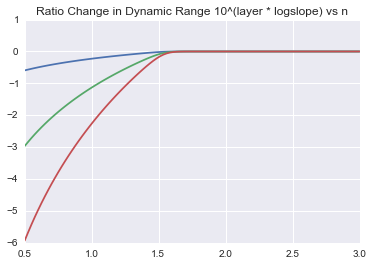

In [151]:
plt.plot(n_array, logslope)
plt.plot(n_array, logslope*5)
plt.plot(n_array, logslope*10)
plt.legend()
plt.title("Ratio Change in Dynamic Range 10^(layer * logslope) vs n")
plt.show()

<h1> Metric: Signal Degradation (Dynamic Range Loss) </h1>


$$ dynamic range = \rho  = 20.0log_{10}(\frac{max}{min}) $$
$$ log_{10}(\rho_{i+j}) = η j + log_{10}(\rho_i) $$
$$ η = log_{10}(\frac{\rho_{i+1}}{\rho_i}) $$
$$ signal degradation = \phi_j = 1 - \frac{\rho_{i+j}}{\rho_i} = 1 - 10^{ηj}$$
$$ j: layers $$
$\phi$ = 1.0: 100% dynamic range loss at x layers

$\phi$ = 0.5: 50% dynamic range loss at x layers

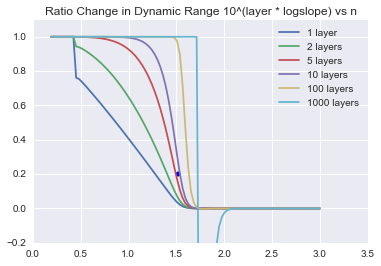

In [153]:
plt.plot(n_array, 1-10**(1*logslope), label="1 layer")
plt.plot(n_array, 1-10**(2*logslope), label="2 layers")
plt.plot(n_array, 1-10**(5*logslope), label="5 layers")
plt.plot(n_array, 1-10**(10*logslope), label="10 layers")
plt.plot(n_array, 1-10**(100*logslope), label="100 layers")
plt.plot(n_array, 1-10**(100000*logslope), label="1000 layers")
plt.scatter(globalparams['mean']['n'], 0.2)
plt.ylim(-0.2, 1.1)
plt.legend()
plt.title("Ratio Change in Dynamic Range 10^(layer * logslope) vs n")
plt.show()

<h1> Hill co-efficient metric plot </h1>

In [139]:
import pandas as pd
import numpy as np
import pylab as plt
read_p = p
dr_diff = read_p['dr_diff']#.iloc[:,25:]
dr_diff = pd.DataFrame(dr_diff.apply(np.mean, axis=1))
dr = read_p['dr']
plt.figure()
#plt.yscale('log')
n0 = read_p['dr_diff'].iloc[:,0]
n11 = read_p['dr_diff'].iloc[:,11]

#plt.scatter(np.array(read_p['n']), n0/n10)
plt.title("Range Plot")
plt.scatter(np.array(read_p['n']), dr_diff)
plt.show()


plt.yscale('linear')
plt.xlim(0.5, 2.5)
plt.ylim(-1, 4)


# Dynamic Range
ss = read_p['ss']
ss_0 = read_p['ss_0']
dynamic_range = np.abs(np.log10(ss) - np.log10(ss_0))
dynamic_range_mean = dynamic_range.iloc[:,4:5].apply(np.mean, axis=1)
dynamic_range_mean2 = dynamic_range.iloc[:,10:11].apply(np.mean, axis=1)
dynamic_range_ratio = dynamic_range_mean2/dynamic_range_mean


l = dynamic_range.transpose()
lsd = dynamic_range.transpose()
lsd = l.apply(np.std, axis=1)
l = l.apply(np.mean, axis=1)
l.plot()
plt.show()

var = dynamic_range_ratio
plt.scatter(np.array(read_p['n']), var)
plt.title("Test Metric")
plt.show()

plt.scatter(np.array(read_p['n']), dynamic_range_mean)
plt.title("Dynamic Range Scatter")
plt.yscale('linear')
plt.xlabel('n')
plt.ylabel('dyanmic range (log(ss/ss_0))')
plt.xlim(0.5, 2.5)
plt.ylim(-1, 4)
plt.savefig("/Users/Justin/Desktop/ModelingAnalysis_9-14-15/DynamicRangeScatterPlot.png")
plt.show()
df = pd.DataFrame(dynamic_range_mean)
df['n'] = np.array(read_p['n'])

#Bin data and calculate standard deviation
#df = pd.DataFrame(dr.iloc[:,4:5].apply(np.mean, axis=1))
#df['n'] = np.array(read_p['n'])
bins = np.arange(df.n.min(), df.n.max(), 0.05)
groups = df.groupby(pd.cut(df.n, bins))
g = groups.mean()
gsd = groups.std()
plt.title("Dynamic Range")
plt.yscale('linear')
plt.xlabel('n')
plt.ylabel('dyanmic range (log(ss/ss_0))')
plt.xlim(0.5, 2.5)
plt.ylim(-1, 4)
plt.errorbar(g['n'], g[0], yerr=gsd[0])
plt.savefig(analysisFolder + "/DynamicRangePlot.png")
dynamicrange_dataframe = pd.DataFrame(
                                        {'n': np.array(g['n']), 
                                       'dynamic range |log(ss) - log(ss_0)|': np.array(g[0]),
                                       'sd': np.array(gsd[0])
                                        })
dynamicrange_dataframe.to_csv(analysisFolder + "dynamicrangeplot.csv")

read_p.to_csv(analysisFolder + "distributionForDynamicRangePlot.csv")

TypeError: list indices must be integers, not str

<h1> Dynamic Range Plot </h1>

In [ ]:
range(20)[0] - range(20)[1]

<h1> Import Dose Response </h1>

strain
6059    0.941733
6325    0.792967
6326    0.644373
6327    0.647548
dtype: float64

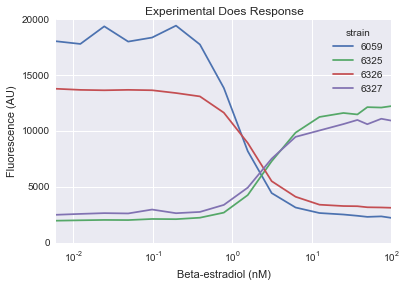

In [9]:
import pandas as pd

exp_dose = pd.read_csv("/Users/Justin/Google Drive/KlavinsLab/Projects/FSM/CSV/20150905_184902_CascadeDoseResponse_Final.csv")
AU = exp_dose['FL1.Amean']
treatment = exp_dose['treatment']
exp_dose = pd.pivot_table(exp_dose, index='treatment', columns=["strain"], values="FL1.Amean")
ax = exp_dose.plot(logx=True)
ax.set_xlabel("Beta-estradiol (nM)")
ax.set_ylabel("Fluorescence (AU)")
ax.set_title("Experimental Does Response")
ax
exp_dose

mx = exp_dose.apply(np.max)
mn = exp_dose.apply(np.min)
np.log10(mx/mn)

In [ ]:
np.arange(0,10,0.1)

<h1> Importing Kinetics Data </h1>

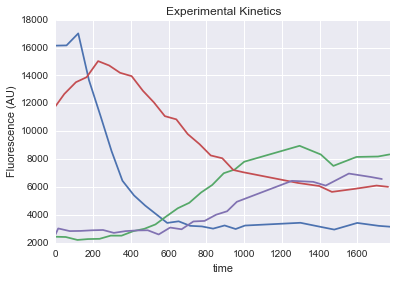

In [8]:
layers1 = pd.read_csv("/Users/Justin/Desktop/DATA/Layer1.csv", header=None)
layers2 = pd.read_csv("/Users/Justin/Desktop/DATA/Layer2.csv", header=None)
layers3 = pd.read_csv("/Users/Justin/Desktop/DATA/Layer3.csv", header=None)
layers4 = pd.read_csv("/Users/Justin/Desktop/DATA/Layer4.csv", header=None)
header = ['time', 'au']
layers1.columns = header
layers2.columns = header
layers3.columns = header
layers4.columns = header
layers1['layer'] = 1
layers2['layer'] = 2
layers3['layer'] = 3
layers4['layer'] = 4
layers = pd.concat([layers1, layers2, layers3, layers4])
layers_table = pd.pivot_table(layers, values='au', columns=['layer'], index='time')
layers.sort(columns=['time', 'layer'])
layers['au'] = layers['au'] + 2000.
layers.stack()
layers
exp_kinetics = pd.pivot_table(layers, values='au', index=['layer', 'time'])
exp_kinetics
plt.figure()
plt.xlabel("Time (min)")
plt.ylabel("Fluorescence (AU)")
plt.title("Experimental Kinetics")
exp_kinetics[1].plot()
exp_kinetics[2].plot()
exp_kinetics[3].plot()
exp_kinetics[4].plot()

<h1> Plot Best Fits </h1>

In [7]:
t_final = 100.

p = pd.read_csv("/Users/Justin/Documents/Programming/CRISPRCascadeAnalysis/Data/hyakfitting_results/bestfits_combined_indexed.csv", header=[0,1], index_col=0)
index = 1
a = list(p.iloc[index]['a'])
k = list(p.iloc[index]['k'])
u = p.iloc[index]['u'][0]
b1, b2 = p.iloc[index]['b']
n = p.iloc[index]['n'][0]

m = ssModel(exp_dose.index, a, k, b2, u, n) * 1600.0
dose_combined = m.join(exp_dose)
k = kineticsModel(a, k, b1, u, n) * 1600.0
k = k.set_index(k.index * 25.0)
k.plot()
exp_kinetics[1].plot()
exp_kinetics[2].plot()
exp_kinetics[3].plot()
exp_kinetics[4].plot()
dose_combined.plot(logx=True)

NameError: name 'exp_dose' is not defined

In [10]:
t_final = 100.
kinetics_trajectories = []
ss_trajectories = []
p = pd.read_csv("/Users/Justin/Documents/Programming/CRISPRCascadeAnalysis/Data/hyakfitting_results/bestfits_combined_indexed.csv", header=[0,1], index_col=0)
for index in range(len(p)):
    index = 1
    a = list(p.iloc[index]['a'])
    k = list(p.iloc[index]['k'])
    u = p.iloc[index]['u'][0]
    b1, b2 = p.iloc[index]['b']
    n = p.iloc[index]['n'][0]

    m = ssModel(exp_dose.index, a, k, b2, u, n) * 1600.0
    k = kineticsModel(a, k, b1, u, n) * 1600.0
    k = k.set_index(k.index * 25.0)
    kinetics_trajectories.append(k)
    ss_trajectories.append(m)

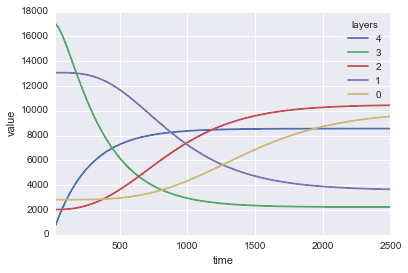

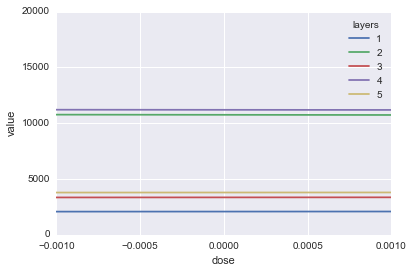

In [14]:
import seaborn as sns
trajectories = kinetics_trajectories
doseresponses = ss_trajectories
for i, t in enumerate(trajectories):
    t['unit'] = i
    t['time'] = t.index
traj_pd = pd.concat(trajectories)
trajmelt = pd.melt(traj_pd, id_vars=["time", "unit"], var_name="layers")
trajmelt['layers'] = max(trajmelt['layers']) - trajmelt['layers']
trajmelt.to_csv(analysisfolder + "Data/MonteCarlo/trajectories.csv")

for i, d in enumerate(doseresponses):
    d['unit'] = i
    d['dose'] = np.log10(d.index)
dose_pd = pd.concat(doseresponses)
dosemelt = pd.melt(dose_pd, id_vars=["dose", "unit", 'rel exp'], var_name="layers")
dosemelt.to_csv(analysisfolder + "Data/MonteCarlo/doseresponses.csv")

trajmelt = trajmelt[trajmelt.layers < 10]
sns.tsplot(data=trajmelt, time="time", unit="unit", condition="layers", value="value", err_style=["boot_traces"], ci=[95])
plt.show()

dosemelt = dosemelt[dosemelt.layers < 10]
sns.tsplot(data=dosemelt, time="dose", unit="unit", condition="layers", value="value", err_style=["ci_band"], ci=[95])
plt.show()

<h1> Fancy plotting of parameters vs metrics </h1>

In [ ]:
sns.set_style("whitegrid")
layer1 = test.stack(level=0).unstack()[0]
layers = []
for l in range(1,29):
    layer = test.stack(level=0).unstack()[l]
    layer['b'] = layer1['b']
    layer['n'] = layer1['n']
    layer['u'] = layer1['u']
    layer['layer'] = l
    layers.append(layer)
layers = pd.concat(layers)
#m = pd.melt(layer, id_vars=['a', 'b', 'k', 'n', 'u'], var_name="metric", value_name="metric_value")
#m = pd.melt(m, id_vars=["metric", "metric_value"], var_name="params", value_name="param_value")


#grid = sns.FacetGrid(m, row="params", col="metric", hue="params")

#grid.map(plt.scatter, "param_value", "metric_value")
#grid.fig.tight_layout(w_pad=1)
#sns.pairplot(layers, hue="layer", x_vars=["a", "b", "k", "n", "u"], y_vars=["dr", "ttss"], kind="reg")
plt.show()
layers['metric'] = layers['dr']/layers['layer']
#sns.jointplot("n", "metric", data=layers)
plt.show()
#sns.tsplot(data=layers, time='n', value="metric", unit="layer")
bins = np.arange(layers.n.min(), layers.n.max(), 0.05)
groups = layers.groupby(pd.cut(layers.n, bins))
g = groups.mean()
gsd = groups.std()
print g
dynamicrange_dataframe = pd.DataFrame(
                                        {'n': np.array(g['n']), 
                                       'metric': np.array(g['metric']),
                                       'sd': np.array(gsd['metric'])
                                        })
plt.errorbar(dynamicrange_dataframe['n'], dynamicrange_dataframe['metric'], yerr=dynamicrange_dataframe['sd'])

<h1> Fancy plotting of models with Seaborn </h1>

In [110]:
import seaborn as sns
trajectories = largeuniform_traj
doseresponses = largeuniform_modelss
for i, t in enumerate(trajectories):
    t['unit'] = i
    t['time'] = t.index
traj_pd = pd.concat(trajectories)
trajmelt = pd.melt(traj_pd, id_vars=["time", "unit"], var_name="layers")
trajmelt['layers'] = max(trajmelt['layers']) - trajmelt['layers']
trajmelt.to_csv(analysisfolder + "Data/MonteCarlo/trajectories.csv")

for i, d in enumerate(doseresponses):
    d['unit'] = i
    d['dose'] = np.log10(d.index)
dose_pd = pd.concat(doseresponses)
dosemelt = pd.melt(dose_pd, id_vars=["dose", "unit", 'rel exp'], var_name="layers")
dosemelt.to_csv(analysisfolder + "Data/MonteCarlo/doseresponses.csv")

trajmelt = trajmelt[trajmelt.layers < 10]
sns.tsplot(data=trajmelt, time="time", unit="unit", condition="layers", value="value", err_style=["ci_band"], ci=[95])
plt.show()

dosemelt = dosemelt[dosemelt.layers < 10]
sns.tsplot(data=dosemelt, time="dose", unit="unit", condition="layers", value="value", err_style=["ci_band"], ci=[95])
plt.show()

KeyboardInterrupt: 